In [1]:
# lstm autoencoder recreate sequence
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.models import Model
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import Activation
from keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def pre_data(file,n_timestep,n_features):
    X = pd.read_csv(file)
    
    X_data = X.values[:,-1-n_features:-1]
    X_data = StandardScaler().fit_transform(X_data) 
    X_data = MinMaxScaler().fit_transform(X_data) 
    n_examples = int(np.shape(X_data)[0]/n_timestep)
    
    X_data = np.reshape(X_data, (n_examples,n_timestep,n_features))
    
    print (np.shape(X_data))
    return (X_data)

In [3]:
file = 'Data/X_train.csv'
n_timestep = 128
n_features = 10

sequence = pre_data(file,n_timestep,n_features)

C:\Users\yizhe\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


(3810, 128, 10)


C:\Users\yizhe\AppData\Local\conda\conda\envs\tf_gpu\lib\site-packages\sklearn\utils\validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [4]:
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_timestep,n_features)))
model.add(RepeatVector(n_timestep)) # repeat the same output for n_timestep times (upsampling)
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.add(Activation('tanh'))
model.summary()
optimizer_Adam = Adam(lr=0.0001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer=optimizer_Adam, loss='mse', metrics=['accuracy'])
## try the lost of binary_crossentropy after normalize the data to 0-1
# fit model
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

# if want to save whole model use h5
mc= ModelCheckpoint("weights_best.hdf5", monitor='val_acc', verbose=1, \
                    save_best_only=True, mode='max')

history = model.fit(sequence, sequence, epochs=2, \
                    batch_size =1000, validation_split = 0.3, \
                    verbose=1, callbacks=[es, mc])


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 100)               44400     
_________________________________________________________________
repeat_vector_1 (RepeatVecto (None, 128, 100)          0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 128, 100)          80400     
_________________________________________________________________
time_distributed_1 (TimeDist (None, 128, 10)           1010      
_________________________________________________________________
activation_1 (Activation)    (None, 128, 10)           0         
Total params: 125,810
Trainable params: 125,810
Non-trainable params: 0
_________________________________________________________________
Train on 2667 samples, validate on 1143 samples
Epoch 1/2
2667/2667 [==============================] - 5s 2ms/step - loss: 0.3116 - acc:

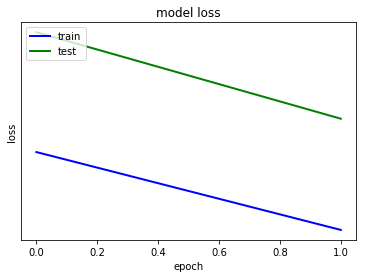

In [5]:
# summarize history for loss
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
line1, = ax.plot(history.history['loss'], color='blue', lw=2)
line, = ax.plot(history.history['val_loss'], color='green', lw=2)

ax.set_yscale('log')
ax.set_title('model loss')
ax.set_ylabel('loss')
ax.set_xlabel('epoch')
ax.legend(['train', 'test'], loc='upper left')

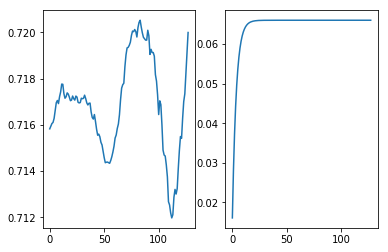

In [6]:
model.load_weights("weights_best.hdf5")
test_ex = sequence[48,:,:]
test_ex = np.expand_dims(test_ex, axis = 0)
y_pred = model.predict(test_ex)

k = 3
plt.subplot(121)
plt.plot(np.squeeze(test_ex[:,:,k]))
plt.subplot(122)
plt.plot(np.squeeze(y_pred[:,:,k]))

In [7]:
# connect the encoder LSTM as the output layer
model = Model(inputs=model.inputs, outputs=model.layers[0].output)
# get the feature vector for the input sequence
yhat = model.predict(sequence)
print(yhat.shape)

(3810, 100)
